In [11]:
%matplotlib inline

from random import choice
from itertools import combinations
from math import factorial
from collections import defaultdict

import nxpd
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import Image
from bokeh.plotting import figure
from bokeh.io import push_notebook, show, output_notebook

output_notebook()

Loading BokehJS ...

In [13]:
def make_subset_graph(elems):
    def _make_graph(current, remaining):
        for elem in remaining:
            new_node = tuple(sorted(current + (elem,)))
            g.add_node(new_node)
            g.add_edge(current, new_node)
            _make_graph(new_node, tuple([e for e in remaining if e != elem]))
                       
    g = nx.DiGraph()
    empty = ()
    g.add_node(empty)
    _make_graph(empty, elems)
    return g

In [14]:
g = make_subset_graph(['a', 'b', 'c', 'd'])

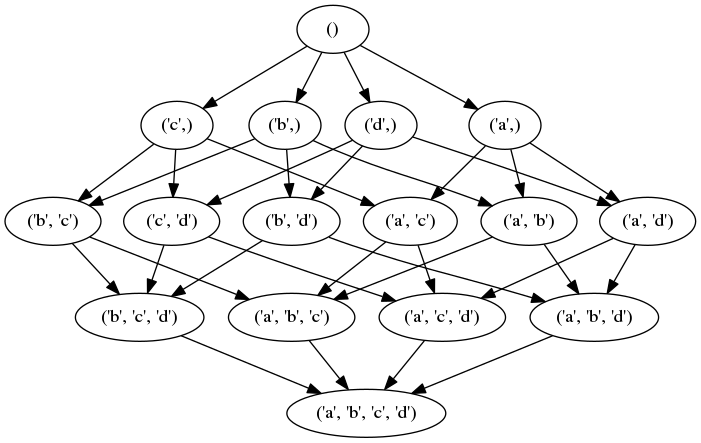

In [16]:
nxpd.draw(g, show='ipynb')

In [17]:
def successors(node, order):
    def next_node(ix):
        new_ix = order_ix[node[ix]] + 1
        new_node = list(node)
        new_node[ix] = order[new_ix]
        return tuple(new_node)
    
    order_ix = {v:i for i, v in enumerate(order)}
    last_elem = order[-1]
    last_ix = len(node) - 1
    succ = []
    for ix, elem in enumerate(node):
        if elem == last_elem:
            continue
        elif ix != last_ix and order_ix[node[ix+1]] - order_ix[elem] == 1:
            continue
        else:
            new_node = list()
            succ.append(next_node(ix))
    return succ

In [18]:
successors(("a", 'c', 'e'), ['a', 'b', 'c', 'd', 'e'])

[('b', 'c', 'e'), ('a', 'd', 'e')]

In [19]:
def make_order_graph(elems):
    index = {v:i for i, v in enumerate(elems)}
    g = make_subset_graph(elems)
    # elems[0] < elems[1] < elems[2] < ...
    last = elems[-1]
    for i in range(len(elems) - 1):
        g.add_edge((elems[i],), (elems[i+1],))
    for n_combs in range(2, len(elems)):
        for node in combinations(elems, n_combs):
            for successor in successors(node, elems):
                g.add_edge(node, successor)
    return g

In [20]:
def topo_sort(graph):
    def visit(node):
        if not marked[node]:
            for neighbor in graph.neighbors(node):
                visit(neighbor)
            marked[node] = True
            res.append(node)
    
    res = []
    marked = defaultdict(lambda: False)
    for node in graph.nodes():
        if not marked[node]:
            visit(node)
    return list(reversed(res))

In [21]:
def coroutine(func):
    def start(*args,**kwargs):
        cr = func(*args,**kwargs)
        next(cr)
        return cr
    return start

In [22]:
def kahn(graph):
    g = graph.copy()
    L = []
    S = [n for n in graph.nodes() if g.out_degree(n) == 0]
    while S:
        n = S.pop()
        L.append(n)
        for m in (m for m, _ in g.in_edges(n)):
            g.remove_edge(m, n)
            if g.out_degree(m) == 0:
                S.append(m)
    if g.edges():
        raise RuntimeError("Graph has at least one cycle")
    else:
        return L

In [23]:
@coroutine
def cr_kahn(graph):
    g = graph.copy()
    L = []
    S = [n for n in graph.nodes() if g.out_degree(n) == 0]
    yield
    while S:
        if len(S) > 1:
            n = (yield S)
            S.remove(n)
        else:
            n = S.pop()
        L.append(n)
        for m in (m for m, _ in g.in_edges(n)):
            g.remove_edge(m, n)
            if g.out_degree(m) == 0:
                S.append(m)
    if g.edges():
        raise RuntimeError("Graph has at least one cycle")
    else:
        return L

In [24]:
def advance_cr_kahn(graph, trace):
    cr = cr_kahn(graph)
    for step in trace:
        cr.send(step)
    return cr

In [25]:
def all_topo_sorts(graph):
    def recurse(trace):
        *init, last = trace
        cr = advance_cr_kahn(graph, init)
        try:
            options = cr.send(last)
        except StopIteration as e:
            res.append(e.value)
        else:
            for option in options:
                recurse(trace + [option])
        
    res = list()
    recurse([None])
    return res

In [26]:
def count_topo_sorts(graph):
    def recurse(trace):
        *init, last = trace
        cr = advance_cr_kahn(graph, init)
        try:
            options = cr.send(last)
        except StopIteration as e:
            nonlocal res
            res +=1
            if res % 10000 == 0:
                print(res)
        else:
            for option in options:
                recurse(trace + [option])
        
    res = 0
    recurse([None])
    return res

In [27]:
def rnd_topo_sorts(graph):        
    num_options = 0
    cr = cr_kahn(graph)
    options = cr.send(None)
    try:
        while True:
            num_options += len(options)
            cr.send(choice(options))
    except StopIteration as e:
        return num_options, e.value

In [28]:
g = make_order_graph(list("abcde"))

In [29]:
count_topo_sorts(g)

KeyboardInterrupt: 